# Table of Content

1. ## [Data Loading](#data-loading)
2. ## [Batch Analysis](#batch-analysis)
3. ## [Word Cloud](#word-cloud)

In [131]:
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random
import geopandas
from datetime import *
from collections import namedtuple

<a name="data-loading"/>

# Data Loading

## Post Data Loading

In [2]:
with open('./final/post_no_content_df.pkl','rb') as f:
    post_df = pickle.load(f)
    test_post_df = post_df.sample(10)
post_df.head()

user_id general_device  censored_post  timestamp_month gender  #tweets  \
0  5711341129          Apple          False     1.627747e+09      f       48   
1  5711341129          Apple          False     1.606752e+09      f       48   
2  5711341129          Apple          False     1.588262e+09      f       48   
0  7412051152           vivo          False     1.627747e+09      m      129   
1  7412051152           vivo          False     1.627747e+09      m      129   

   #follower  #following  verification  #censored_posts  \
0        193         394         False                0   
1        193         394         False                0   
2        193         394         False                0   
0          1          38         False                1   
1          1          38         False                1   

   #follower_percentile_grouped province  #collected_posts  province_gdp  \
0                             7       其他                 3             0   
1                             7       其他                 3             0   
2                             7       其他                 3             0   
0                             1       其他                52             0   
1                             1       其他                52             0   

   censored_user  censored_ratio  
0          False        0.000000  
1          False        0.000000  
2          False        0.000000  
0           True        0.019231  
1           True        0.019231

## User Data Loading 

In [3]:
with open('final/user_df.pkl', 'rb') as f:
    users_with_content = pickle.load(f)
users_with_content.head()

id gender  #tweets  #follower  #following  verification  \
536321  2453175617      f        2          0         172         False   
278927  2123046974      f        8          0          18         False   
405016  1883592641      m      724          0        1215         False   
234168  2639003040      m       32          0          51         False   
151815  2045211094      m       15          0          48         False   

        #censored_posts  #follower_percentile_grouped province  \
536321                0                             1       其他   
278927                0                             1       其他   
405016                1                             1       其他   
234168               14                             1       其他   
151815                0                             1       河南   

        #collected_posts  province_gdp  censored  censored_ratio  
536321                 1             0     False        0.000000  
278927                 3             0     False        0.000000  
405016                58             0      True        0.017241  
234168                62             0      True        0.225806  
151815                 4          8302     False        0.000000

In [136]:
with open('final/user_df.pkl', 'rb') as f:
    users_with_content = pickle.load(f)
users_with_content.head()

id gender  #tweets  #follower  #following  verification  \
536321  2453175617      f        2          0         172         False   
278927  2123046974      f        8          0          18         False   
405016  1883592641      m      724          0        1215         False   
234168  2639003040      m       32          0          51         False   
151815  2045211094      m       15          0          48         False   

        #censored_posts  #follower_percentile_grouped province  \
536321                0                             1       其他   
278927                0                             1       其他   
405016                1                             1       其他   
234168               14                             1       其他   
151815                0                             1       河南   

        #collected_posts  province_gdp  censored  censored_ratio  
536321                 1             0     False        0.000000  
278927                 3             0     False        0.000000  
405016                58             0      True        0.017241  
234168                62             0      True        0.225806  
151815                 4          8302     False        0.000000

## Map Data Loading

In [7]:
china_geo_df = geopandas.read_file('china.json')
china_geo_df.head()

id size name  childNum                                           geometry
0  65  550   新疆        18  POLYGON ((96.41600 42.75880, 96.41600 42.71480...
1  54  550   西藏         7  POLYGON ((79.01370 34.32130, 79.10160 34.45310...
2  15  450  内蒙古        12  POLYGON ((97.20700 42.80270, 99.49220 42.58300...
3  63  800   青海         8  POLYGON ((89.73630 36.07910, 89.91210 36.07910...
4  51  900   四川        21  POLYGON ((101.77730 33.53030, 101.86520 33.574...

<a name="batch-analysis"/>

# Batch Analysis

In [89]:
AnalysisFunc = namedtuple(
    'AnalysisFunc', 
    ["analyze_func", "columns_selector", "chart_analysis_name","override_chart_type", "applicable_dfs"],
    defaults = [None, {"User", "Post"}]
)

Column = namedtuple(
    'Column',
    ["col_name", "chart_name", "chart_type", "chart_args", "post_process_mapping", "applicable_dfs"],
    defaults = [None, None, {"User", "Post"}]
)

In [90]:
metrics = [
    AnalysisFunc(
        "mean",
        lambda df: df['censored_post'] if 'censored_post' in df.columns else df['censored'], 
        "Censored {} Ratio"
    ),
    AnalysisFunc(
        len, 
        lambda df: df['gender'], 
        "{} Count"
    ),
    AnalysisFunc(
        "sum",
        lambda df: df['censored_post'] if 'censored_post' in df.columns else df['censored'], 
        "Censored {} Count"
    ),
    AnalysisFunc(
        "mean",
        lambda df: df['censored_ratio'],
        "Average User Censorship Ratio",
        applicable_dfs = {'User'}
    )
]

In [132]:
columns = [
    Column(
        None, 
        "Nothing", 
        "bar", 
        post_process_mapping=lambda _ : "Total Population",
        chart_args={'color':(0.9,0.0,0.9)}
    ),
    Column(
        "gender", 
        "Gender", 
        "bar", 
        chart_args={"rot":0,"xlabel":"Gender", 'color':(0.0,0.0,0.9)}, 
        post_process_mapping={"f":"Female", "m":"Male"}
    ),
    Column(
        "gender", 
        "Gender", 
        "pie", 
        post_process_mapping={"f":"Female", "m":"Male"},
        applicable_dfs = {"User"}
    ),
    Column(
        "verification", 
        "Verification Status", 
        "bar",
        chart_args = {"rot":0, 'color':(0.0,0.9,0.0)},
        post_process_mapping={True: "Verified", False: "Unverified"}
    ),
    Column(
        "verification", 
        "Verification Status", 
        "pie",
        post_process_mapping={True: "Verified", False: "Unverified"},
        applicable_dfs = {"User"}
    ),
    Column(
        "province", 
        "Province",
        "map"
    ),
    Column(
        "#follower_percentile_grouped", 
        "Follower Count Percentile", 
        "bar",
        chart_args = {"xlabel":"Quantile of Number of Followers(Scaled by 10)","rot":0, 'color':(0.0,0.9,0.9)}
    ),
    Column(
        "general_device",
        "Device",
        "bar",
        chart_args = {"rot":60,"xlabel":"Device", 'color':(0.9,0.0,0.0)},
        applicable_dfs = {"Post"}
    )
]

In [133]:
all_dfs = {
    "User": users_with_content,
    "Post": post_df
}

In [134]:
def plot(out_df, chart_type, **kwargs):
    value_column = out_df.columns[0]
    title = kwargs['title']
    
    if chart_type == "bar":
        kwargs.setdefault('color',(random.random(),random.random(),random.random()))
        kwargs.setdefault('figsize', (9,6))
        ax = out_df.plot.bar(**kwargs)
        
    elif chart_type == "map":
        count_map = china_geo_df.merge(out_df, left_on='name', right_on=out_df.columns[0],right_index=True)
        kwargs.setdefault('figsize', (9,6))
        kwargs.setdefault('legend', True)
        kwargs.setdefault('legend_kwds',{'label': kwargs['title'],'shrink': 0.6})
        kwargs.pop('title')
        ax = count_map.plot(column=value_column, **kwargs)
        ax.set_title(title)
        
    elif chart_type == "pie":
        # default values
        kwargs.setdefault('figsize', (9,6))
        kwargs.setdefault('shadow',True)
        kwargs.setdefault('startangle', 90)
        kwargs.setdefault('autopct','%1.1f%%')
        kwargs.setdefault('labeldistance', 1.05)
        kwargs.setdefault('normalize', True)
        kwargs.pop('color',None)
        ax = out_df.plot.pie(y=value_column, **kwargs)
    
    ax.get_figure().savefig('./figures/%s.png' % title)

def analyze(df, analysis, col, df_title):
    useful_series = analysis.columns_selector(df)
    col_name = 'None' if col.col_name is None else col.col_name
    analysis_w_table_name = analysis.chart_analysis_name.format(df_title)
    useful_df = pd.DataFrame({
        col_name: df[col.col_name] if col.col_name is not None else [True] * len(df),
        analysis_w_table_name: useful_series
    })
    output = useful_df.groupby(col_name).agg(analysis.analyze_func)
    if col.post_process_mapping is not None:
        output.reset_index(inplace=True)
        output[col_name] = output[col_name].map(col.post_process_mapping)
        output.set_index(col_name, inplace=True)
    title = f"{analysis_w_table_name} Group by {col.chart_name}" if col.col_name is not None else f"{analysis_w_table_name} in the Collected Data"
    plot(output, 
         col.chart_type, 
         title = title, 
         **(col.chart_args or {})
        )
    '''
    with open('%s.pkl' %title,'wb') as f:
        pickle.dump(output, f)
    '''

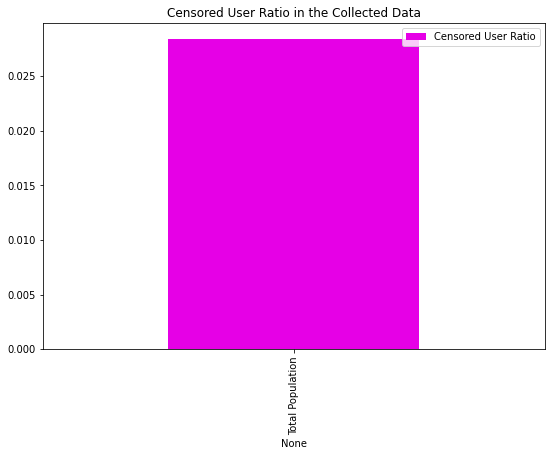

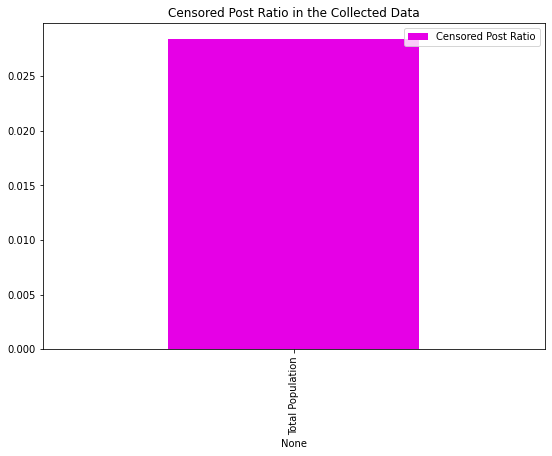

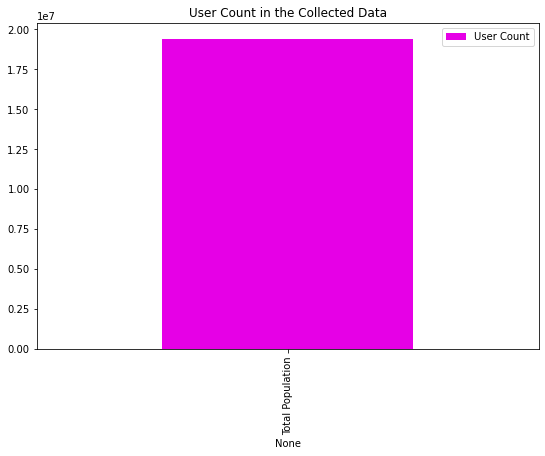

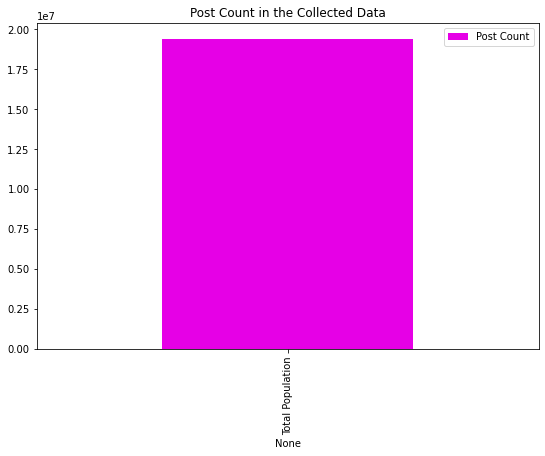

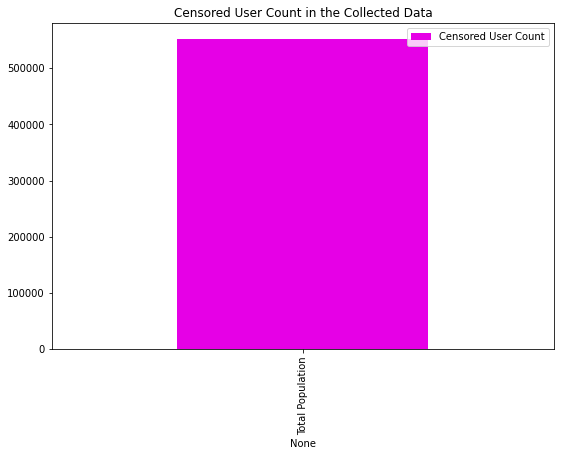

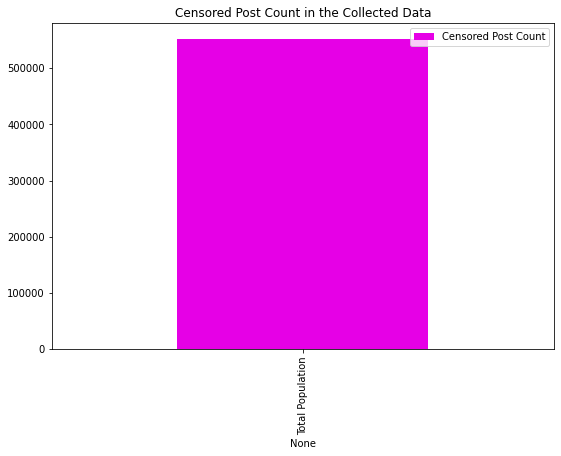

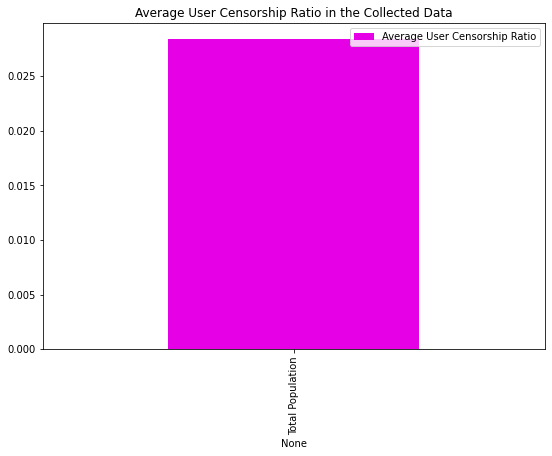

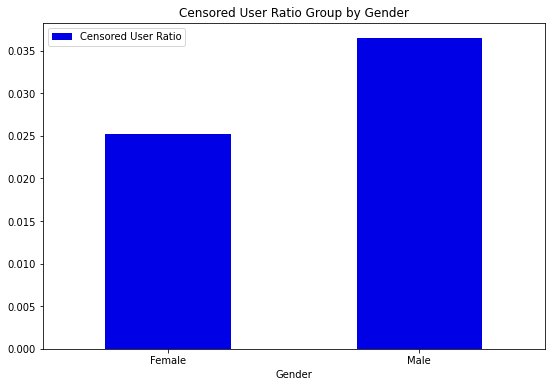

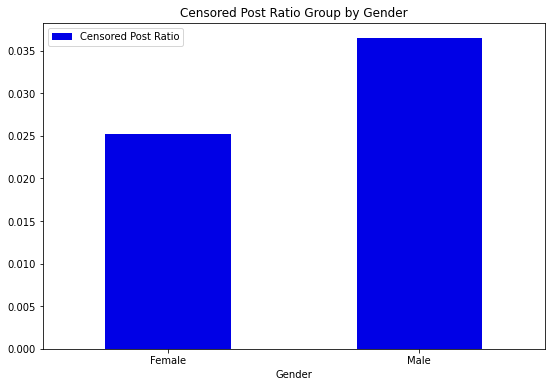

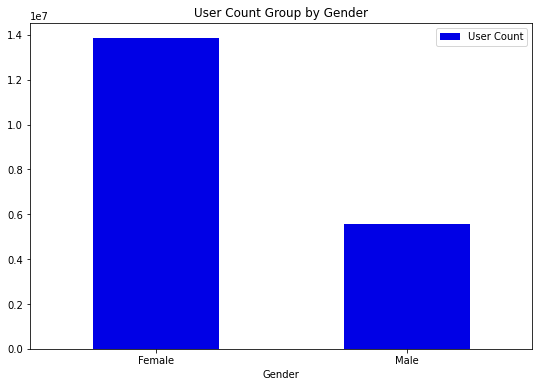

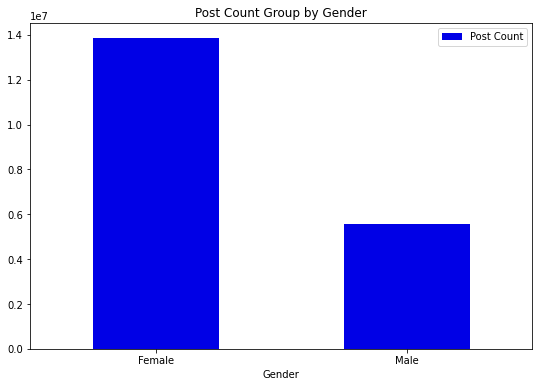

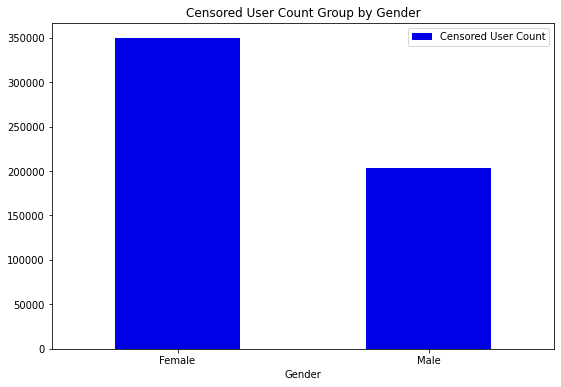

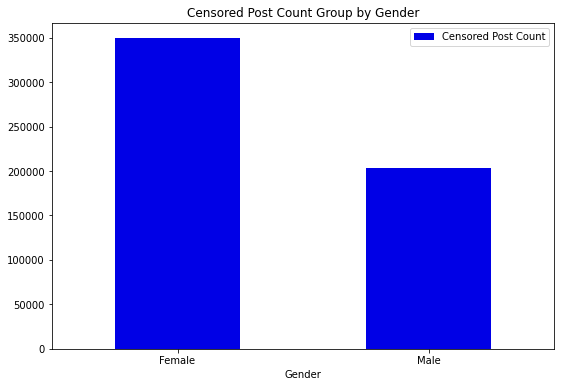

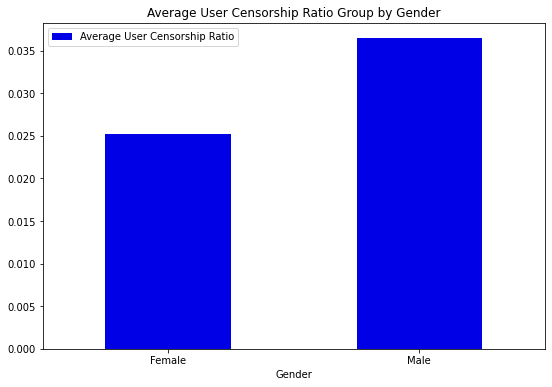

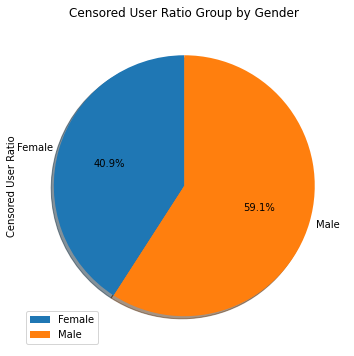

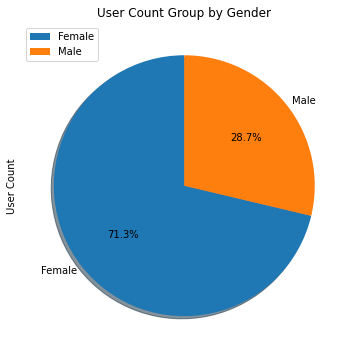

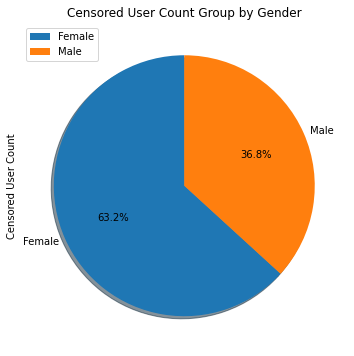

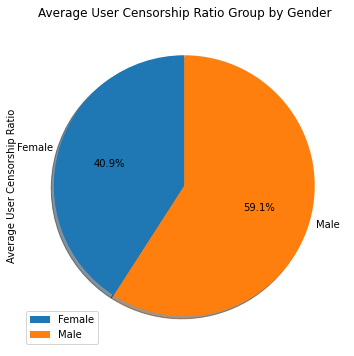

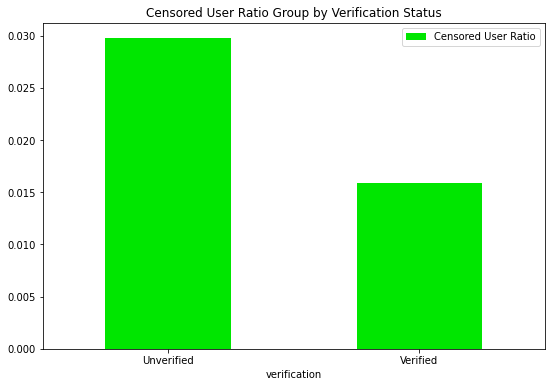

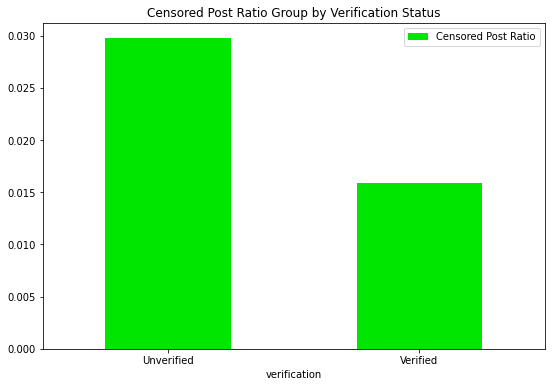

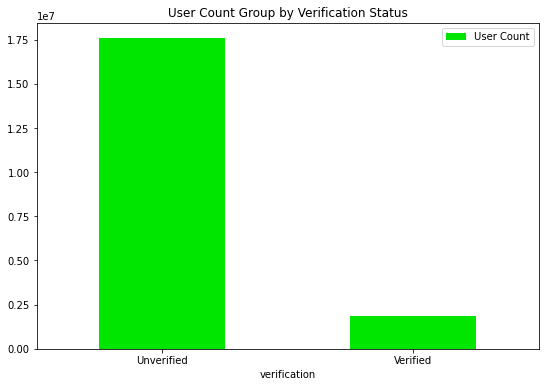

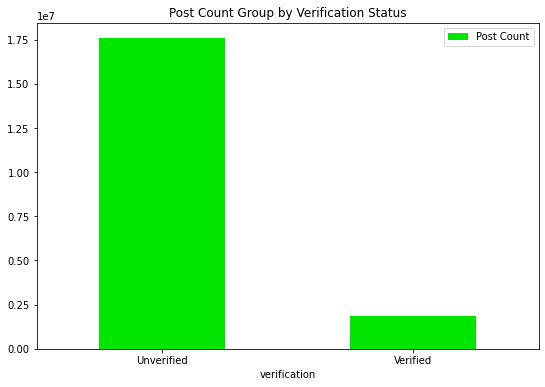

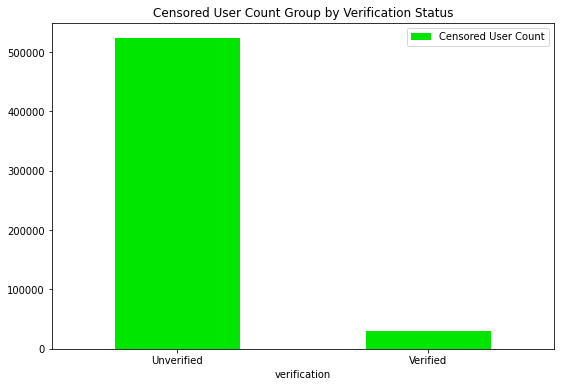

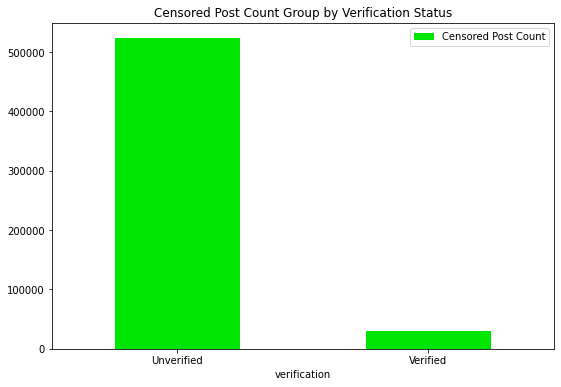

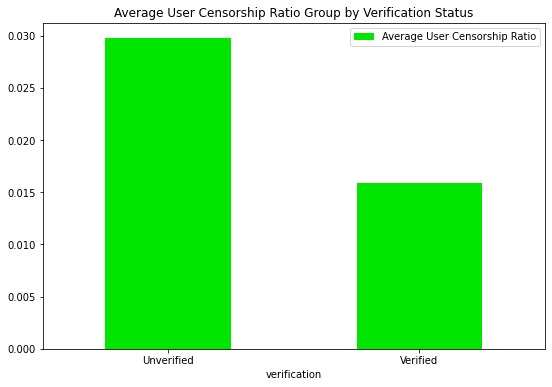

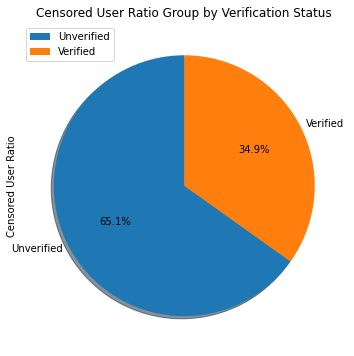

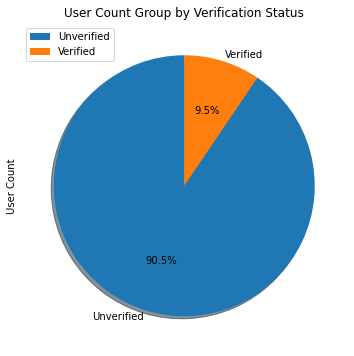

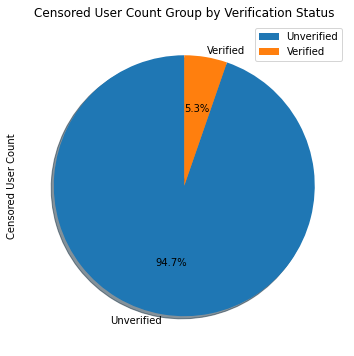

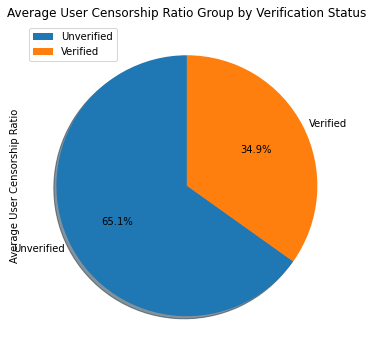

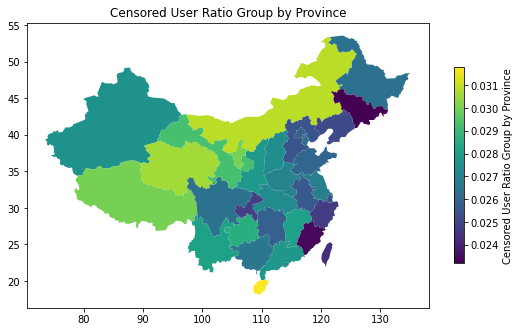

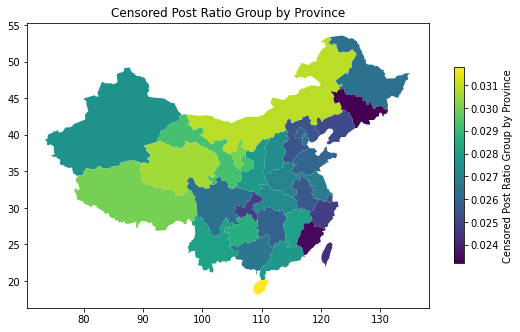

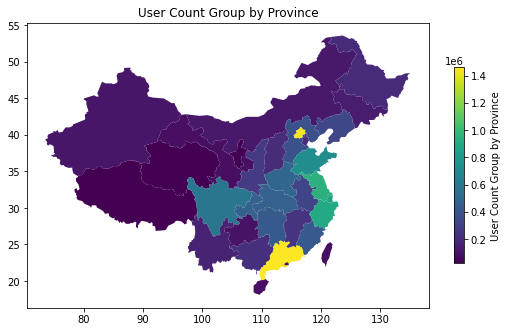

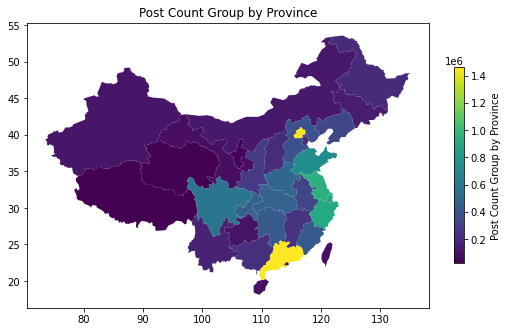

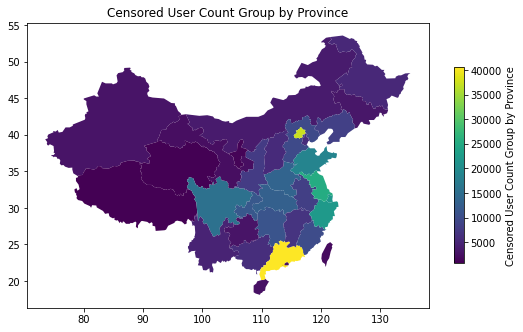

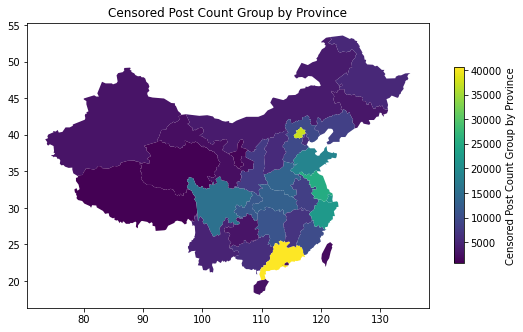

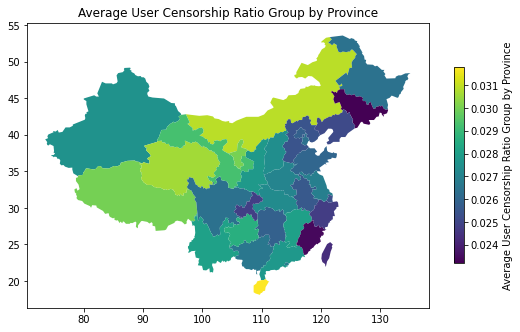

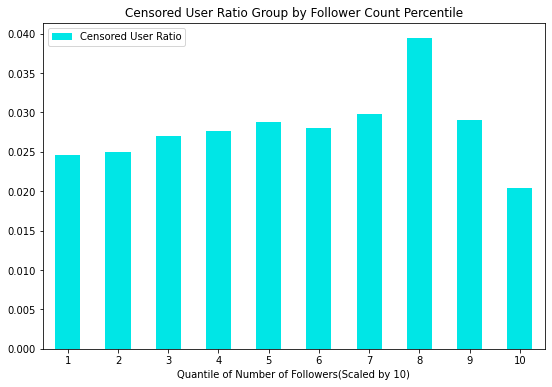

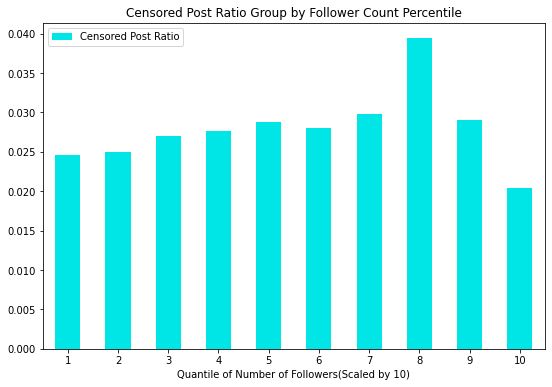

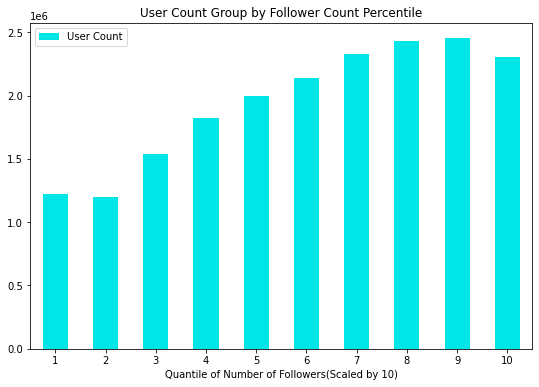

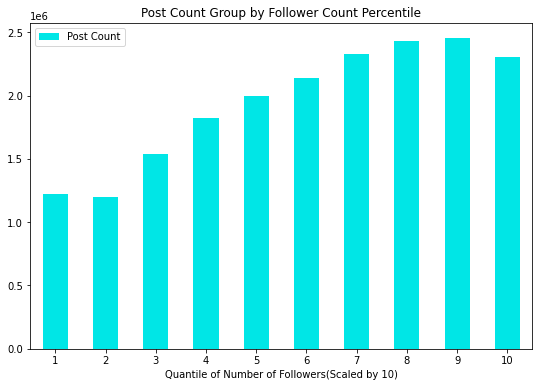

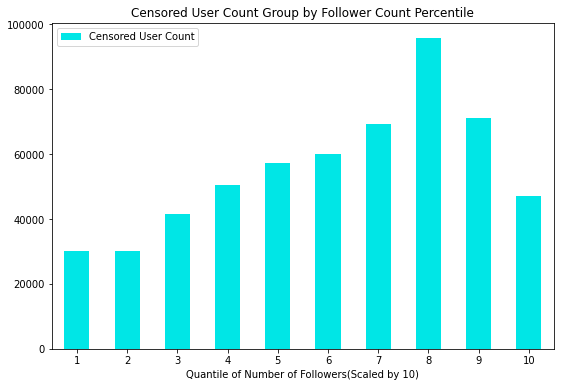

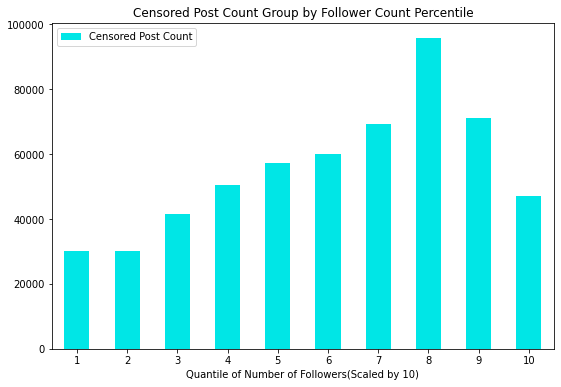

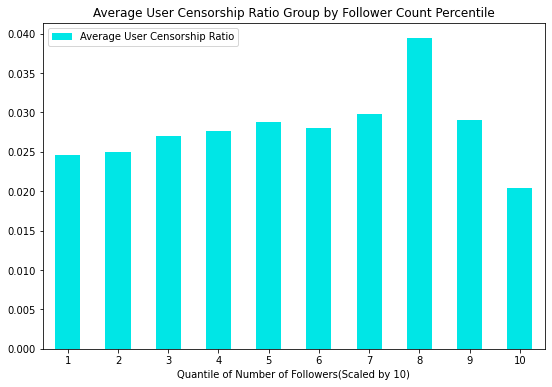

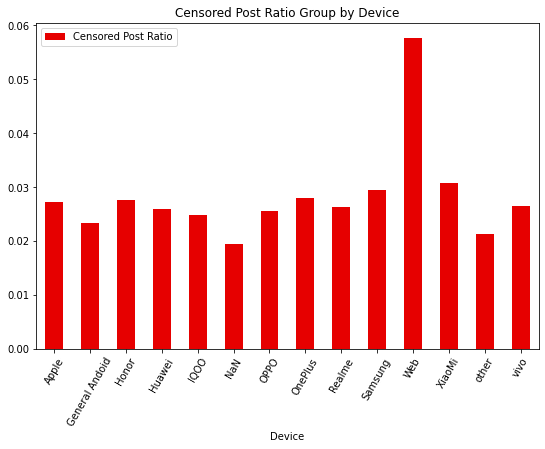

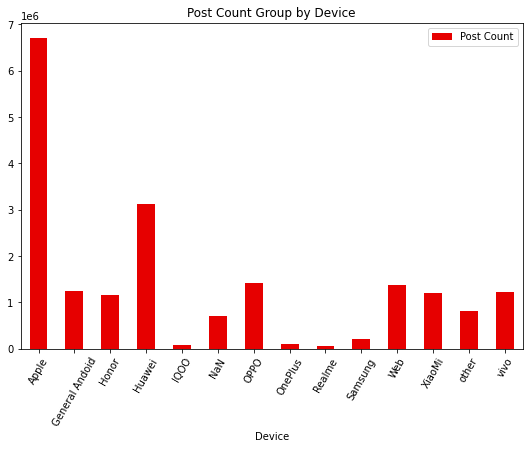

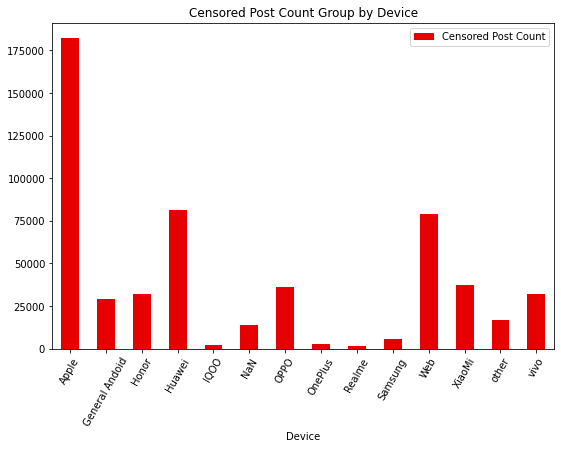

In [135]:
plt.rcParams.update({'figure.max_open_warning': 0}) # Suppress max plot num open warning
for groupby_col in columns:
    for analysis in metrics:
        for df_title, df in all_dfs.items():
            if df_title in groupby_col.applicable_dfs and df_title in analysis.applicable_dfs:
                analyze(post_df, analysis, groupby_col, df_title)

<a name="word-cloud"/>

# Word Cloud

## Topic Extraction -makeup

In [170]:
with open('topic_models.pkl','rb') as f:
    models = pickle.load(f)

In [174]:
from google.cloud import translate_v2 as translate
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="translator-47347b8d079f.json"
translate_client = translate.Client()
print(type(translate_client))


<class 'google.cloud.translate_v2.client.Client'>


In [184]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from random import choice
lda_best = models[6]
topics_best = []
lda_best.print_topics(num_topics=9, num_words=20)
for topic in lda_best.print_topics(num_topics=9,num_words=20):
    topics_best.append(topic[1])
    
# take topics to dictionary
def convert_to_dict(topic: str):
    frequency_dict = {}
    for i in [i.split('*') for i in topic.split('+')]:
        frequency_dict[i[1].strip().replace('"','')] = float(i[0]) * 1e3
    return frequency_dict

# take topics to a translated dictionary
def convert_to_dict_trans(topic: str):
    frequency_dict = {}
    for i in [i.split('*') for i in topic.split('+')]:
        frequency_dict[translate_client.translate(i[1].strip().replace('"',''), target_language='en')['translatedText']] = float(i[0]) * 1e3
    return frequency_dict

# draw a word cloud for each sub-topic
def cloud_each_topic(topics:list,model_name:str,trans:bool):
    for i in range(len(topics)):
        topic_words = topics[i]
        if trans:
            freq_dict = convert_to_dict_trans(topic_words)
        else:
            freq_dict = convert_to_dict(topic_words)
        draw_cloud(freq_dict,1,'%s_%d' %(model_name,i))
        
def my_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return choice(["rgb(94,38,18)", "rgb(41,36,33)", "rgb(128,128,105)", "rgb(112,128,105)"])

def draw_cloud(word_freq,tp:0, name_file:str): #tp = 0 means general, tp = 1 means the plot for each subtopic
    if tp == 0:
        width = 800
        height = 400
    else:
        width = 400
        height = 200
    wc = WordCloud(font_path='HuaWenHeiTi-1.ttf',  # 设置字体
                   background_color="white",  # 背景颜色
                   max_words=300,  # 词云显示的最大词数
                   max_font_size=80,  # 字体最大值
                   random_state=42,
                   width = width,
                   height = height)
    
    wc.generate_from_frequencies(word_freq)

    plt.figure(figsize=(10,5))
    plt.imshow(wc.recolor(color_func=my_color_func), interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wc.to_file('./figures/%s.png' %name_file)

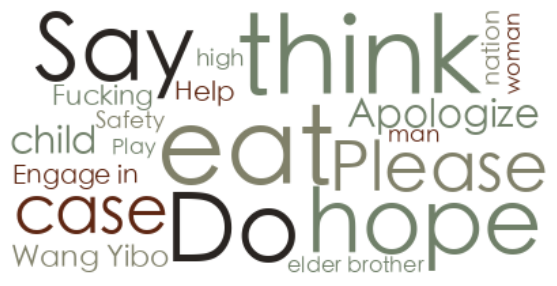

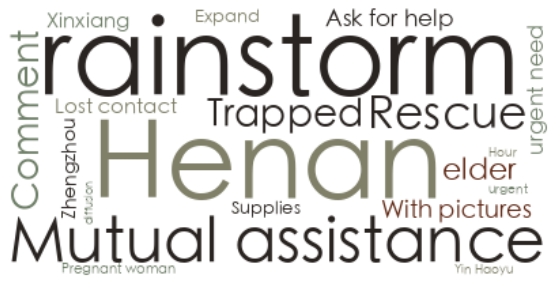

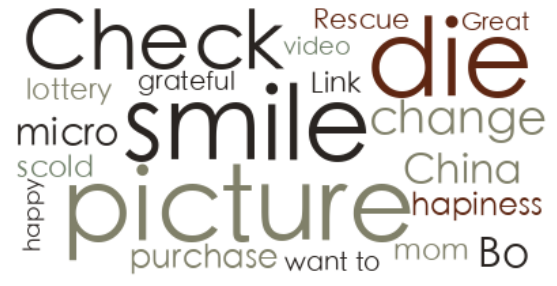

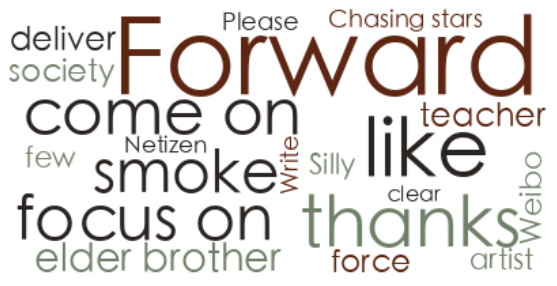

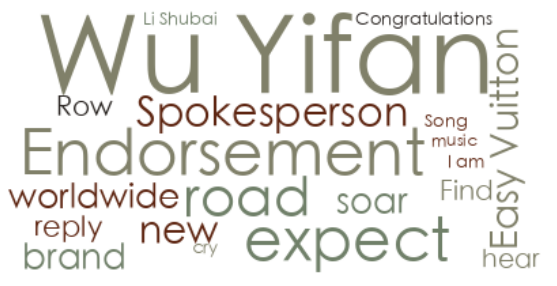

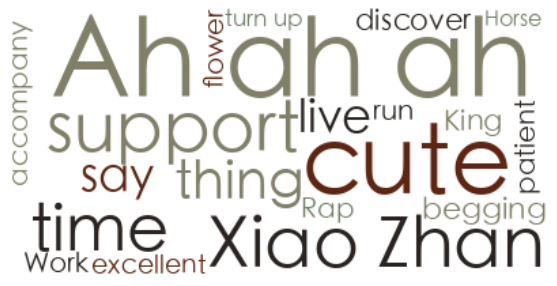

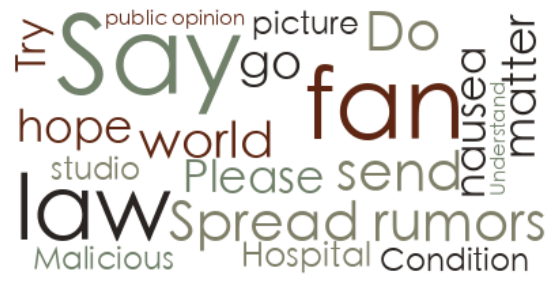

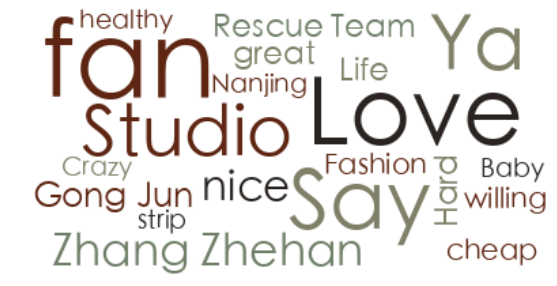

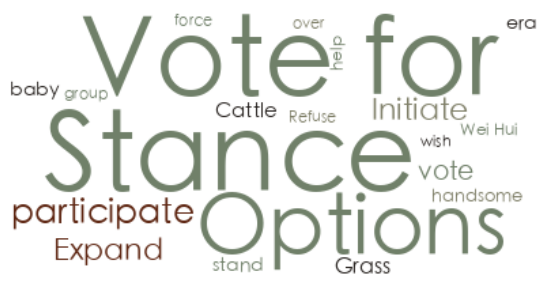

In [185]:
cloud_each_topic(topics_best,'best_model_trans',True)

## A module to take a peek at the topics in a certain area

In [202]:
import jieba
import jieba.posseg
from wordcloud import WordCloud, STOPWORDS
from gensim.models import CoherenceModel
from gensim import corpora, models, similarities
import gensim
import re

my_file = open('complete_stop_words.txt',encoding="utf8")
stop_words = my_file.read().splitlines()

def cut_words_with_pos(text):
    seg = jieba.posseg.cut(text)
    res = []
    for word, flag in seg:
        if flag in ["a", "v", "x", "n", "an", "vn", "nz", "nt", "nr", "ns", "nw", "eng"] and (word not in stop_words):
            res.append(word)
    return list(res)

def corpus_generation(df):
    corpus = np.array(df['repost_weibo_comment'])
    corpus = corpus[~pd.isnull(corpus)]
    corpus = [str(i) for i in corpus]
    # segregate comments from multiple reposters
    corpus_segregated = []
    for i in corpus:
        split_repost = re.findall(r'(?<=//@).+?(?=/|$)',i)
        if split_repost:
            corpus_segregated += [i[i.find(':')+1:] for i in split_repost]
        else:
            corpus_segregated.append(i)
    # further clean the corpus_segragated
    corpus_segregated = [i for i in corpus_segregated if i] #get rid of empty strings
    corpus_segregated = [i for i in corpus_segregated if i != '转发微博' and i != 'repost' and i != '轉發微博' and i != 'Repost'] #take out default wordings
    # take the non-chinese, non-english and non-numeric characters out of the corpus while keeping some normal punctuation marks
    pattern = re.compile(r'[^\u4e00-\u9fa5^a-z^A-Z^0-9\u3002\uff1b\uff0c\uff1a\u201c\u201d\uff08\uff09\u3001\uff1f\u300a\u300b]')
    corpus_segregated = list(map(lambda x: re.sub(pattern,'',x), corpus_segregated))
    corpus_segregated = [i for i in corpus_segregated if i]
    corpus_flat_refiend = []
    for sentence in corpus_segregated:
        corpus_flat_refiend += cut_words_with_pos(sentence)
    # take the frequency of each word
    frequency_dict = {key:0 for key in set(corpus_flat_refiend)}
    for i in corpus_flat_refiend:
        frequency_dict[i] += 1
    ranked_frequency_dict = {k: v for k, v in sorted(frequency_dict.items(), key=lambda item: item[1], reverse=True)}
    translated_frequency_dict = {}
    for key,value in list(ranked_frequency_dict.items())[:1000]:
        translated_key = translate_client.translate(key, target_language='en')['translatedText']
        translated_frequency_dict[translated_key] = value
    translated_frequency_dict['Louis Vuitton']= translated_frequency_dict.pop('Easy Vuitton')
    # to decompose each sentence into key words refined by jieba
    sentences = []
    for i in corpus_segregated:
        sentences.append(cut_words_with_pos(i))
    # bag of words model
    dictionary = corpora.Dictionary(sentences)
    corpus_topic = [dictionary.doc2bow(sentence) for sentence in sentences]

    return sentences, dictionary, corpus_topic, frequency_dict, translated_frequency_dict

def compute_coherence_values(dictionary, corpus, sentences):
    """
    Compute u_mass coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(3,15),position=0):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary,num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,texts=sentences, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# take topics to dictionary
def convert_to_dict(topic: str):
    frequency_dict = {}
    for i in [i.split('*') for i in topic.split('+')]:
        frequency_dict[i[1].strip().replace('"','')] = float(i[0]) * 1e3
    return frequency_dict

# take topics to a translated dictionary
def convert_to_dict_trans(topic: str):
    frequency_dict = {}
    for i in [i.split('*') for i in topic.split('+')]:
        frequency_dict[translate_client.translate(i[1].strip().replace('"',''), target_language='en')['translatedText']] = float(i[0]) * 1e3
    return frequency_dict

# draw a word cloud for each sub-topic
def cloud_each_topic(topics:list,model_name:str,trans:bool):
    for i in range(len(topics)):
        topic_words = topics[i]
        if trans:
            freq_dict = convert_to_dict_trans(topic_words)
        else:
            freq_dict = convert_to_dict(topic_words)
        draw_cloud(freq_dict,1,'%s_%d' %(model_name,i))

def my_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return choice(["rgb(94,38,18)", "rgb(41,36,33)", "rgb(128,128,105)", "rgb(112,128,105)"])

def draw_cloud(word_freq,tp:0, name_file:str): #tp = 0 means general, tp = 1 means the plot for each subtopic
    if tp == 0:
        width = 800
        height = 400
    else:
        width = 400
        height = 200
    wc = WordCloud(font_path='HuaWenHeiTi-1.ttf',  # 设置字体
                   background_color="white",  # 背景颜色
                   max_words=300,  # 词云显示的最大词数
                   max_font_size=80,  # 字体最大值
                   random_state=42,
                   width = width,
                   height = height)
    
    wc.generate_from_frequencies(word_freq)

    plt.figure(figsize=(10,5))
    plt.imshow(wc.recolor(color_func=my_color_func), interpolation='bilinear')
    plt.axis("off")
    plt.show()
    #wc.to_file('./figures/%s.png' %name_file)        

def find_location_topic(location:str, wo_censor:bool, year:None, month:None):
    list_df_w_censor = []
    list_df_wo_censor = []
    year_timestamp = 
    for i in tqdm(range(12)):
        with open('./final/post_full_df_%d.pkl' %i, 'rb') as f:
            df_w_post = pickle.load(f)
        df_w_post_censor = df_w_post[(df_w_post['province']==location) & (df_w_post['censored_post']==True)]
        if year:
            # take out nan values
            df_w_post_censor = df_w_post_censor[~df_w_post_censor['timestamp_month']]
            df_w_post_censor = df
        list_df_w_censor.append(df_w_post_censor)
        if wo_censor:
            df_w_post_wo_censor = df_w_post[(df_w_post['province']==location) & (df_w_post['censored_post']==False)]
            list_df_wo_censor.append(df_w_post_wo_censor)
    df_repost_censor = pd.concat(list_df_w_censor)
    if wo_censor:
        df_repost_wo_censor = pd.concat(list_df_wo_censor) 
    sentences, dictionary, corpus, frequency_dict, translated_frequency_dict = corpus_generation(df_repost_censor)
    # plot the general wc
    draw_cloud(frequency_dict,0,'general_wc_%s' %location)
    draw_cloud(translated_frequency_dict,0,'translated_general_wc_%s' %location)
    # find the best topics
    models, coherence_values = compute_coherence_values(dictionary,corpus,sentences)
    best_model = models[coherence_values.index(max(coherence_values))]
    topics_best = []
    for topic in best_model.print_topics(num_topics=coherence_values.index(max(coherence_values))+3, num_words=20):
        topics_best.append(topic[1])
    # best model to word cloud
    cloud_each_topic(topics_best,'best_model_%s' %location,False)
    cloud_each_topic(topics_best,'best_model_trans_%s' %location,True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:47<00:00,  4.00s/it]


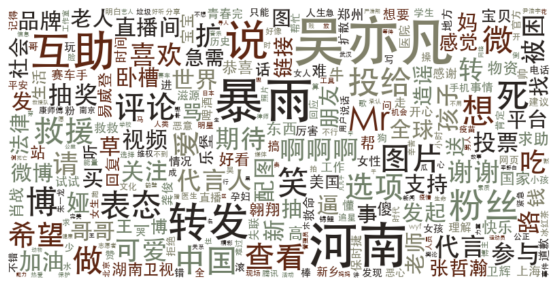

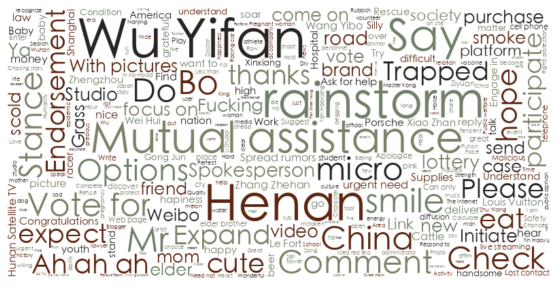

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:41<00:00,  3.43s/it]


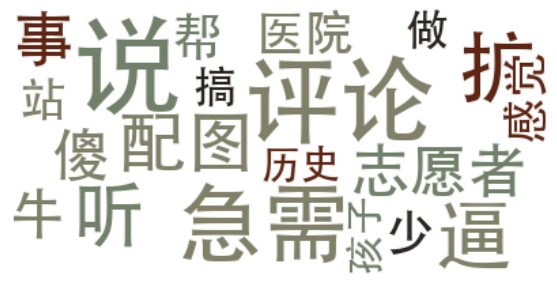

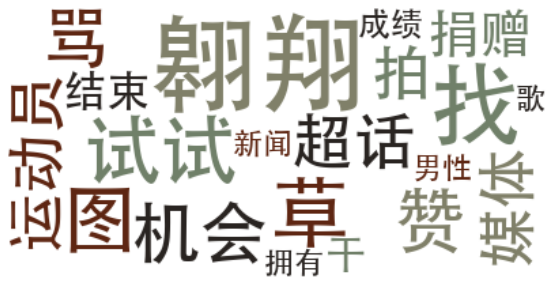

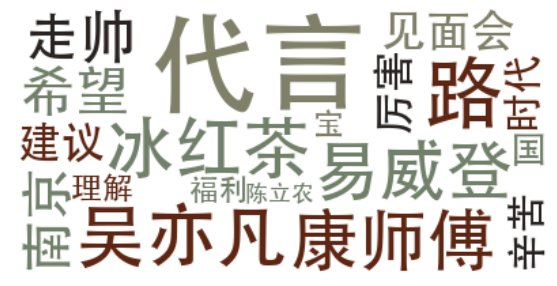

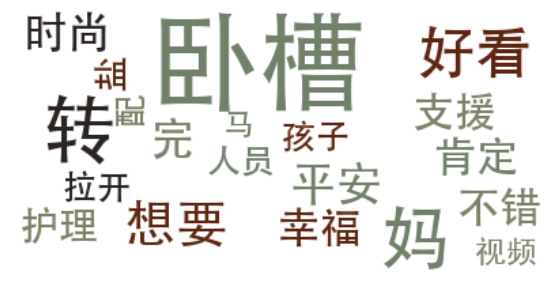

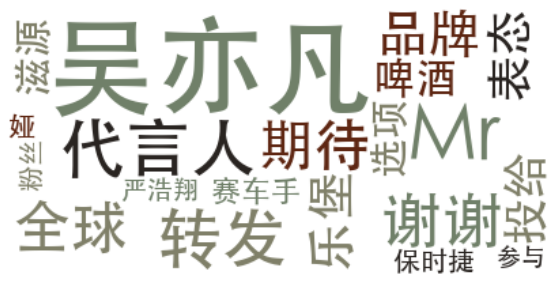

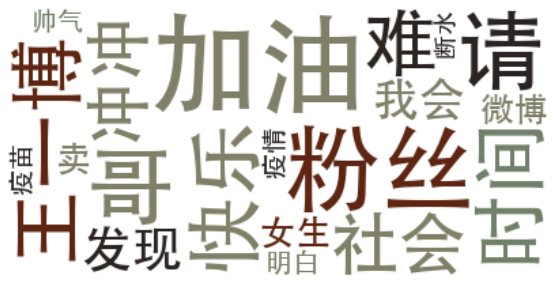

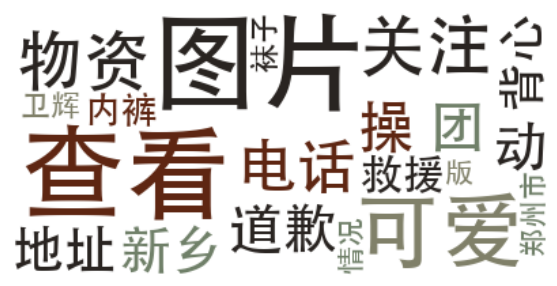

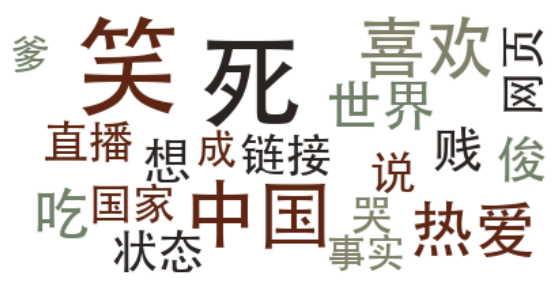

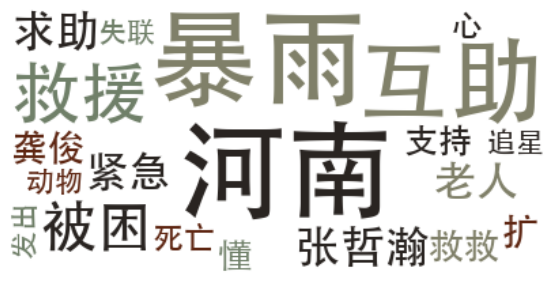

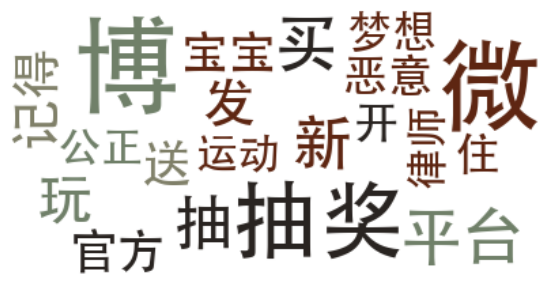

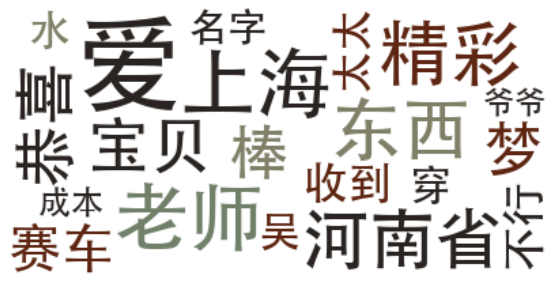

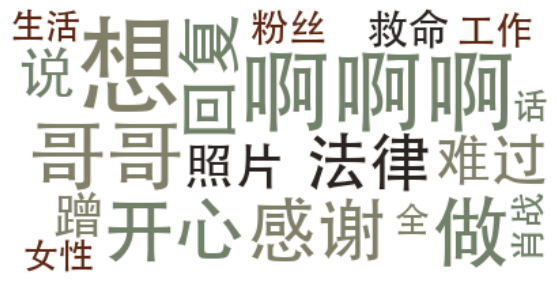

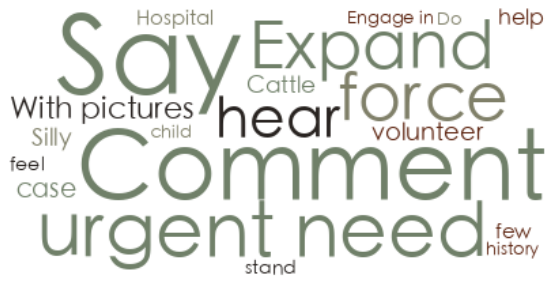

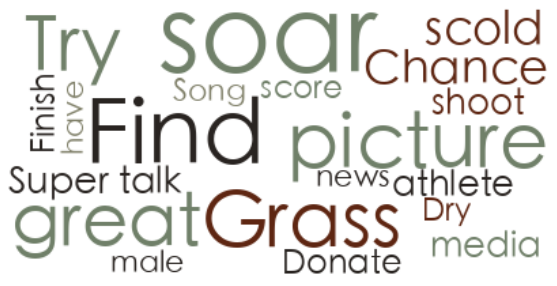

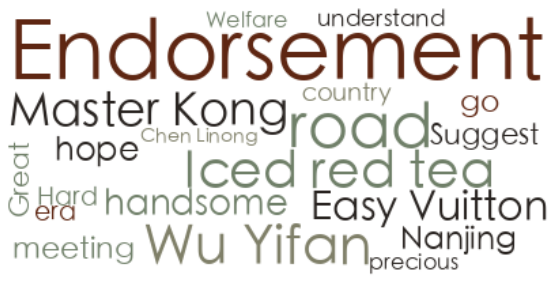

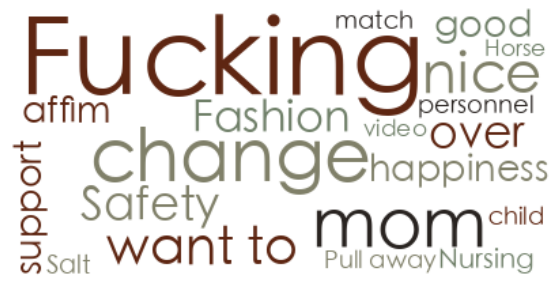

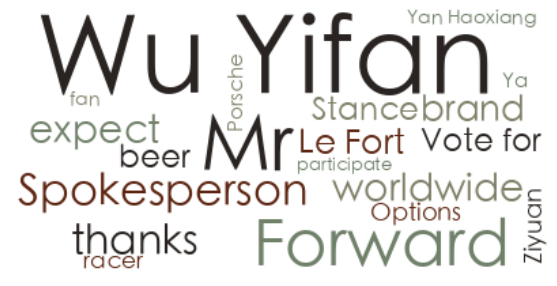

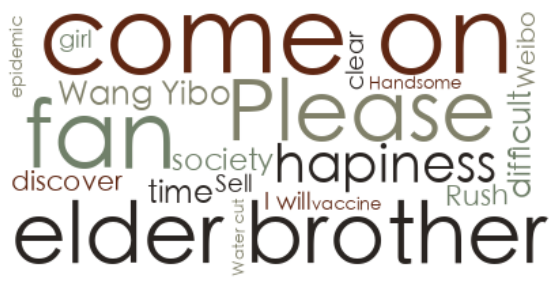

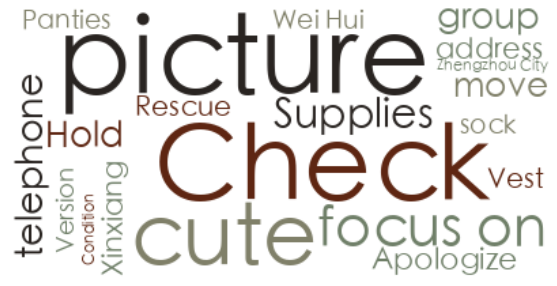

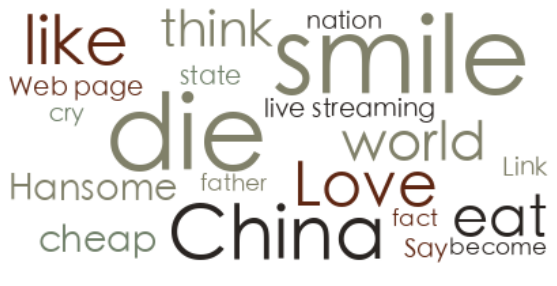

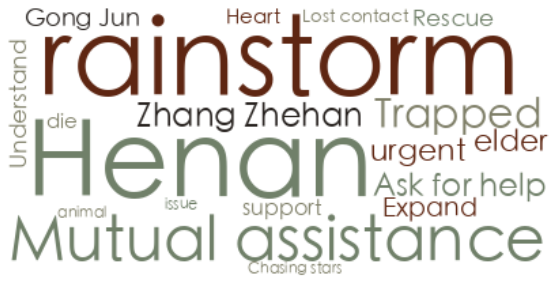

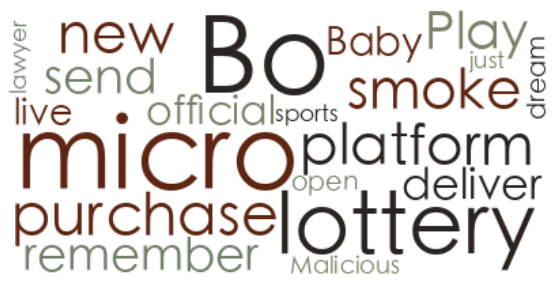

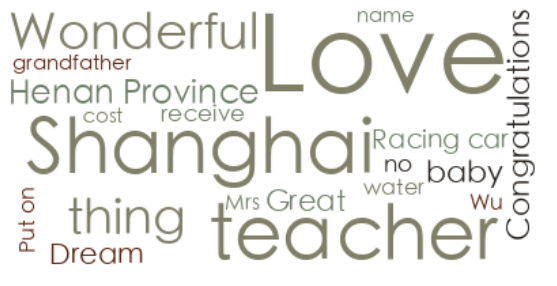

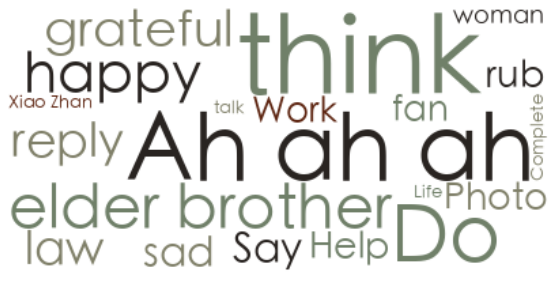

In [203]:
find_location_topic('上海',False)

In [275]:
dt_object = datetime.fromtimestamp(temp_df['timestamp_month'].iloc[1]).strftime('%Y-%m')
dt_object

'2020-11'

In [233]:
a = datetime.strptime('2021-7','%Y-%m')
a.timestamp()

1625097600.0

In [248]:
temp_df['timestamp_month'][0].map(lambda x: datetime.fromtimestamp(x).strptime('2021-7','%Y-%m'))

ValueError: Invalid value NaN (not a number)

In [277]:
a =map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m'),list(temp_df['timestamp_month'].values))

repost_weibo_comment source_weibo_content     user_id general_device  \
0                     0                   18  6434735528            NaN   
1                     0                   37  6434735528            NaN   
2                     0                  774  6434735528            NaN   
3                     0                  584  6434735528            NaN   
4                     0                35267  6434735528            NaN   
..                  ...                  ...         ...            ...   
36                    0                   19  3800833351            NaN   
37                    0                  399  3800833351            NaN   
0                     1                  138  6325684814            NaN   
0                     2                  529  6644008312            NaN   
0                     0               589738  7403182444            NaN   

    censored_post  timestamp_month gender  #tweets  #follower  #following  \
0           False              NaN      f      254        126         597   
1           False              NaN      f      254        126         597   
2           False              NaN      f      254        126         597   
3           False              NaN      f      254        126         597   
4           False              NaN      f      254        126         597   
..            ...              ...    ...      ...        ...         ...   
36          False              NaN      f      345        405         219   
37          False              NaN      f      345        405         219   
0           False              NaN      m        7          2         303   
0           False              NaN      f       18          2         272   
0           False              NaN      f        4          1         177   

    verification  #censored_posts  #follower_percentile_grouped province  \
0          False                0                             7       北京   
1          False                0                             7       北京   
2          False                0                             7       北京   
3          False                0                             7       北京   
4          False                0                             7       北京   
..           ...              ...                           ...      ...   
36          True                0                             9       北京   
37          True                0                             9       北京   
0          False                0                             1       其他   
0          False                0                             1       其他   
0          False                0                             1       其他   

    #collected_posts  province_gdp  censored_user  censored_ratio  
0                 55         23805          False             0.0  
1                 55         23805          False             0.0  
2                 55         23805          False             0.0  
3                 55         23805          False             0.0  
4                 55         23805          False             0.0  
..               ...           ...            ...             ...  
36                38         23805          False             0.0  
37                38         23805          False             0.0  
0                  1             0          False             0.0  
0                  2             0          False             0.0  
0                  2             0          False             0.0  

[2306 rows x 18 columns]

In [299]:
temp_df[temp_df['repost_weibo_comment']==0]

repost_weibo_comment source_weibo_content     user_id general_device  \
0                     0                   18  6434735528            NaN   
1                     0                   37  6434735528            NaN   
2                     0                  774  6434735528            NaN   
3                     0                  584  6434735528            NaN   
4                     0                35267  6434735528            NaN   
..                  ...                  ...         ...            ...   
33                    0               150486  3800833351            NaN   
34                    0                 3677  3800833351            NaN   
35                    0                  331  3800833351            NaN   
36                    0                   19  3800833351            NaN   
37                    0                  399  3800833351            NaN   

    censored_post  timestamp_month gender  #tweets  #follower  #following  \
0           False              NaN      f      254        126         597   
1           False              NaN      f      254        126         597   
2           False              NaN      f      254        126         597   
3           False              NaN      f      254        126         597   
4           False              NaN      f      254        126         597   
..            ...              ...    ...      ...        ...         ...   
33          False              NaN      f      345        405         219   
34          False              NaN      f      345        405         219   
35          False              NaN      f      345        405         219   
36          False              NaN      f      345        405         219   
37          False              NaN      f      345        405         219   

    verification  #censored_posts  #follower_percentile_grouped province  \
0          False                0                             7       北京   
1          False                0                             7       北京   
2          False                0                             7       北京   
3          False                0                             7       北京   
4          False                0                             7       北京   
..           ...              ...                           ...      ...   
33          True                0                             9       北京   
34          True                0                             9       北京   
35          True                0                             9       北京   
36          True                0                             9       北京   
37          True                0                             9       北京   

    #collected_posts  province_gdp  censored_user  censored_ratio  
0                 55         23805          False             0.0  
1                 55         23805          False             0.0  
2                 55         23805          False             0.0  
3                 55         23805          False             0.0  
4                 55         23805          False             0.0  
..               ...           ...            ...             ...  
33                38         23805          False             0.0  
34                38         23805          False             0.0  
35                38         23805          False             0.0  
36                38         23805          False             0.0  
37                38         23805          False             0.0  

[1419 rows x 18 columns]